# Music Genre Classification using convolutional neural network (CNN) models and Mel-frequency coefficients (MFCCs)

## 0. Importing libraries, setting up device agnostic code

We start by importing the main needed libraries to run the script. Then we check the GPU properties and set up device agnostic code. In this manner, if a GPU is available, it will be used. Furthermore, we set a random seed so that a fixed seed will maintain consistency in experimental results. This will also make it easier to compare different approaches.

In the case of CNNs, setting a random seed is not enough to create results that will be consistent no matter how many times one runs the notebook code. This is due to two settings in the backend code:
* `torch.backends.cudnn.deterministic`: Setting this bool to **True** will make the cuDNN (stands for CUDA Deep Neural Network library) to only use deterministic algorithms. However those algorithms are not always optimized and as a result, the code will run slower.
* `torch.backends.cudnn.benchmark`: Setting this bool to **True** will make the cuDNN to benchmark multiple convolution algorithms and select the fastest. This prevents us from having the same results every time we run the code. At the same time, it is obvious that it also affects speed.

In [84]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchaudio
import torch.nn as nn
from torchaudio.datasets import GTZAN
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

2.7.0+cu118
2.7.0+cu118


In [85]:
# Set random seeds
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# The following setting affect the training time (increasing it 10-20%):

# Only use deterministic convolution algorithms
torch.backends.cudnn.deterministic = True

# Turn off "benchmark of convolution algorithms and selecting the fastest", in order to have repeatability in the results
torch.backends.cudnn.benchmark = False

In [86]:
!nvidia-smi

Sun Nov 16 16:38:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX150         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   53C    P8            N/A  / 5001W |       0MiB /   2048MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [87]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Loading data

We load the data from the respective `.json` file in the current directory. Data is loaded as numpy arrays. Those arrays are used to create PyTorch tensors. We are also going to create a *classes* list in order to use the name of the classes for predictions later.

The CNN models expect the following shape as input: `(batch_size, channels, mfcc_coeficient, time_frame)`. As a result we are going to use the `permute()` method in order to have the tensors in the intended shape.

In [88]:
# Create function to load mfcc data from json file
DATASET_PATH = "data_full.json"

def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

    # Convert
    X = np.array(data['mfcc'])
    y = np.array(data['labels'])

    return X, y

In [89]:
# Create function to load classes from json file
DATASET_PATH = "data_full.json"

def load_classes(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)
    classes = data['mapping']
    return classes

In [90]:
# Load classes
classes = load_classes(DATASET_PATH)
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [91]:
# Load data
inputs, labels = load_data(DATASET_PATH)
inputs.shape, labels.shape

((9996, 130, 13), (9996,))

In [92]:
# Turn data into tensors, also unsqueeze and permute, to be ready for CNN
X = torch.from_numpy(inputs).float() # Weight calculations expect float
y = torch.from_numpy(labels).long() # CrossEntropyLoss expects long
X = X.permute(0, 2, 1).unsqueeze(1)
X.shape, y.shape

(torch.Size([9996, 1, 13, 130]), torch.Size([9996]))

## 2. Create DataSets and DataLoaders

In order to use the data in our model, we have to organize it into PyTorch DataLoaders.
After loading the data, we split them into three sets: train_set, validation_set and test_set. The validation_set will be used during the training for evaluation. The test_set will be used after the model is ready. In order for it to be exposed in never seen data.

After dividing the sets, we create the respective datasets and dataloaders.

In [93]:
# Creating a function to divide the sets
def divide_sets(X, y, test_size, validation_size, random_state=None):

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [94]:
# Create train, validation and test sets test size is 25% of the whole set. Validation size is 20% of the remaining train_set
X_train, X_validation, X_test, y_train, y_validation, y_test = divide_sets(X, y, test_size=0.25,
                                                                                validation_size=0.2,
                                                                                random_state=RANDOM_SEED)


In [95]:
# Check if data is divided correctly
print(X.shape[0] == X_train.shape[0] + X_validation.shape[0] + X_test.shape[0])
print(y.shape[0] == y_train.shape[0] + y_validation.shape[0] + y_test.shape[0])

True
True


In [96]:
# Create datasets and dataloaders
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE=32
torch.manual_seed(RANDOM_SEED)

train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=BATCH_SIZE,)
test_dataloader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(validation_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000215BD42BF10>, <torch.utils.data.dataloader.DataLoader object at 0x0000021588D6DF10>)
Length of train dataloader: 188 batches of 32
Length of validation dataloader: 47 batches of 32
Length of test dataloader: 79 batches of 32


In [97]:
# Checking the dataset shapes using test_dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(test_features_batch.shape, "-> (batch_size, num_channels, mfcc_coefficients, time_frames)")
print(test_labels_batch.shape, "-> (batch_size,) each entry is the class index of a sample)")
print(test_features_batch[0].shape, "-> (num_channels, mfcc_coefficients, time_frames)")
print(test_labels_batch[0], "-> (label)")

torch.Size([32, 1, 13, 130]) -> (batch_size, num_channels, mfcc_coefficients, time_frames)
torch.Size([32]) -> (batch_size,) each entry is the class index of a sample)
torch.Size([1, 13, 130]) -> (num_channels, mfcc_coefficients, time_frames)
tensor(1) -> (label)


## 3. Data visualization

For better perception of the subject, we implement some visualization of the data. We use matplotlib libraries to visualize an mfcc representation of the first example. The data has to be turned into numpy arrays in order to be processed by matplotlib.
In the picture, we can distinguish the 13 coefficients in the vertical axis as parallel lines of the same thickness.

A second visualization is implemented later, in order to view various representations of different genres.

The music genre of each representation can also be viewed.


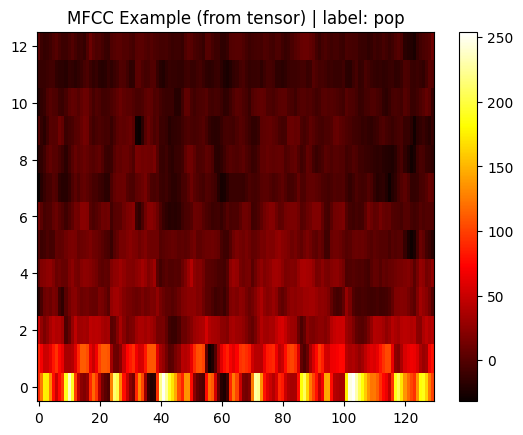

In [98]:
# Visualise data
np.random.seed(RANDOM_SEED)
CLASS_NUM = np.random.randint(len(X))
mfcc_example = X[CLASS_NUM].squeeze(0).numpy() # squeeze is used because shape is (1, 13, 130)
plt.imshow(mfcc_example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar()
plt.title(f"MFCC Example (from tensor) | label: {classes[y[CLASS_NUM]]}")
plt.show()

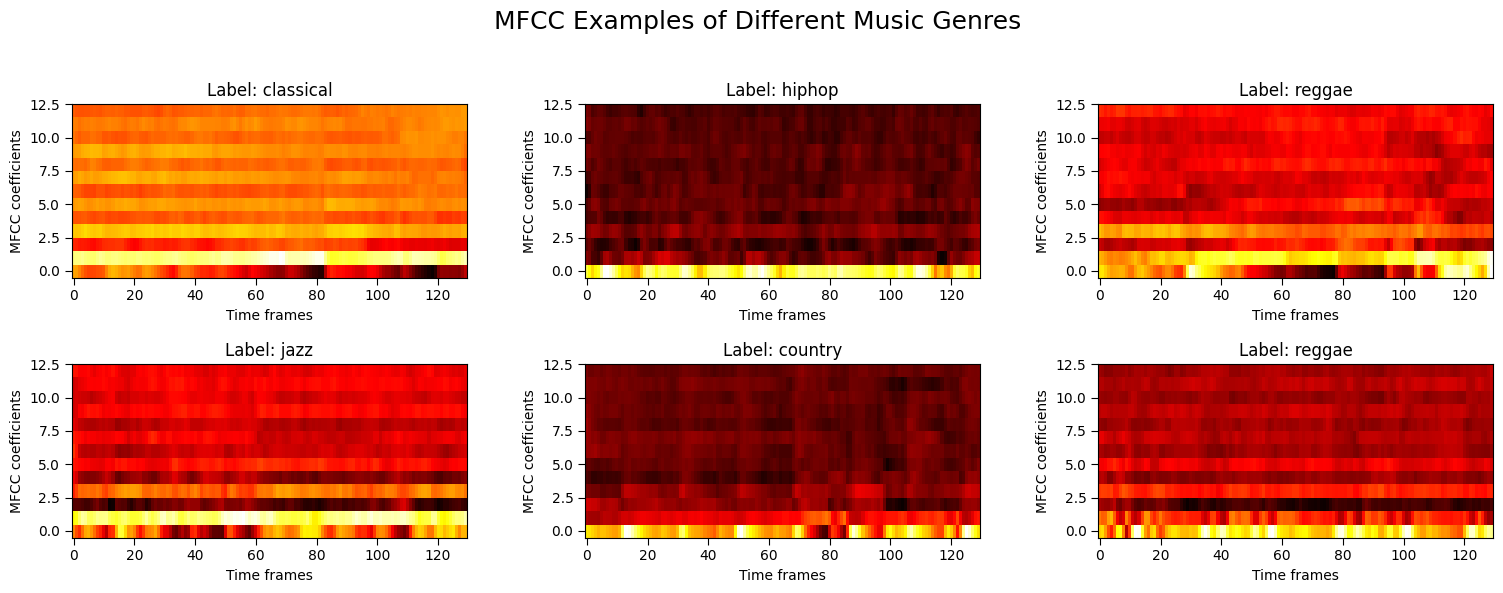

In [99]:
# Vizualize different genres
np.random.seed(RANDOM_SEED)
indices = np.random.choice(len(X), size=6, replace=False)

fig, axs = plt.subplots(2, 3, figsize=(15, 6),constrained_layout=False)
fig.suptitle("MFCC Examples of Different Music Genres", fontsize=18)

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3
    mfcc_example = X[idx].squeeze(0).numpy()
    im = axs[row, col].imshow(mfcc_example, cmap='hot', aspect='auto', origin='lower')
    axs[row, col].set_title(f"Label: {classes[y[idx]]}")
    axs[row, col].set_xlabel("Time frames")
    axs[row, col].set_ylabel("MFCC coefficients")
    axs[row, col].tick_params(axis='both', which='both', length=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

## 5. Building a basic CNN model

The architecture of the model is based on a CNN. It uses 3 convolution blocks. Each one consist of a `Conv2d` layer, following a `ReLu()` activation and applying pooling with `MaxPool2d()`. We also use `BatchNorm2d()` in the end. This method helps with reducing the danger of the vanishing/exploding gradients problems. The convolution blocks are followed by a classification block. This consists of two linear layers. The first is activated using `ReLu()` and also a `Dropout()` layer is implemented, to reduce the chances of overfitting. This block acts somehow like a multi-perceptron block, so it takes a vector as input. For that purpose, in the beggining we use a `Flatten()` layer.

A common problem that rises when compiling a CNN model with PyTorch, is that we do not know the shape of the matrix that will occur after implementing the `Flatten()` layer. There are many ways to solve this problem. For that purpose, we include `print()` functions in the `forward()` method. What we do is, we run sample data through the model for a run that will fail. However, due to the `print()` functions, we will be able to see the shape of the matrix after the `Flatten()` layer. The numbers of the shape, are the ones we have to multiply the input_shape of the next `linear()` layer with.

This model will output logits. We can apply an `nn.Softmax()` function to those logits in order to get probabilities. However it is good practise to do this later. Furthermore we are going to use `nn.CrossEntropyLoss` later and this method takes logits as arguments.

In [100]:
# Compile the network
class CNNClassifierV0(nn.Module):
    def __init__(self, input_shape: int = 1,
                 hidden_units:int = 32,
                 output_shape: int = 10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.BatchNorm2d(hidden_units),
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.BatchNorm2d(hidden_units),
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2,
                         padding=1),
            nn.BatchNorm2d(hidden_units),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 1 * 16,
                      64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

# Create a model and put it to device
torch.manual_seed(RANDOM_SEED)
model_0 = CNNClassifierV0(input_shape=1,
                          hidden_units=32,
                          output_shape=10).to(device)
model_0

CNNClassifierV0(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3

In [101]:
# Try a forward pass to find shape that enters classifier
# Extract a sample batch and print shape
sample_batch, label_batch = next(iter(train_dataloader))
print(sample_batch.shape)
print(label_batch.shape)

# Do a test forward pass and print first five logits and probs
logits = model_0(sample_batch.to(device))
probs = torch.softmax(logits, dim=1)
print(logits[:5])
print(probs[:5])

torch.Size([32, 1, 13, 130])
torch.Size([32])
tensor([[ 0.0723,  0.1357, -0.0276, -0.2475, -0.0561,  0.0662,  0.2812,  0.1257,
          0.3070,  0.1346],
        [ 0.0703,  0.0691,  0.1142,  0.1514, -0.2119,  0.0564,  0.3432,  0.3610,
         -0.1595, -0.0748],
        [-0.5032,  0.0696, -0.0357,  0.0506,  0.1468, -0.0501,  0.2032,  0.2284,
          0.0787, -0.1535],
        [-0.2098,  0.2525,  0.0807,  0.4059, -0.0635, -0.1349,  0.7546,  0.4174,
          0.2352, -0.0244],
        [ 0.0156, -0.1172,  0.2397, -0.4165, -0.1946, -0.2428,  0.3997,  0.0473,
          0.0521,  0.0820]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[0.0982, 0.1046, 0.0888, 0.0713, 0.0863, 0.0976, 0.1210, 0.1036, 0.1241,
         0.1045],
        [0.0982, 0.0981, 0.1027, 0.1065, 0.0741, 0.0969, 0.1291, 0.1314, 0.0781,
         0.0850],
        [0.0591, 0.1049, 0.0944, 0.1029, 0.1133, 0.0930, 0.1198, 0.1229, 0.1058,
         0.0839],
        [0.0655, 0.1040, 0.0876, 0.1212, 0.0758, 0.0706, 0.1718, 0.1

## 6. Training the model

We start by setting a loss function and an optimizer. Two crucial elements of the training procedure. The optimizer carries a `weight_decay`, this is going to add an L2 regularization to avoid overfitting.

In order to implement the training pipeline, we will create two separate functions:
* `train_step()`: This function is responsible for the training of the model. It also includes the logic for calculating the accuracy. We could use `torchmetrics.accuracy()`, but instead one can calculate it. We use the `argmax()` method after applying a `softmax()` on the logits that are extracted from the model. This calculation gives us the predicted label, because it returns the index of the highest probability. After that, the accuracy is calculated as the sum of predicted labels that are the same as the labels, divided by the number of samples.
* `test_step()`: This function will evaluate the loss and accuracy on a set. Initially we will use it on the evaluation set during training.

Those two functions are combined in the `train()` function in order to train the model for a set number of epochs. We also use the `timeit` library to set a timer in order to time the training. The `train()` function returns a dictionary with the results, in order to use them for plotting.

In [102]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

In [103]:
# Create a train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [104]:
# Create test loop function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [105]:
# Create train function by combining train_step and test_step
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [106]:
# Train the model
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4615 | train_acc: 0.4679 | test_loss: 1.0924 | test_acc: 0.5950
Epoch: 2 | train_loss: 1.1105 | train_acc: 0.5992 | test_loss: 0.9390 | test_acc: 0.6611
Epoch: 3 | train_loss: 0.9448 | train_acc: 0.6619 | test_loss: 0.8299 | test_acc: 0.6941
Epoch: 4 | train_loss: 0.8321 | train_acc: 0.7063 | test_loss: 0.7932 | test_acc: 0.7226
Epoch: 5 | train_loss: 0.7531 | train_acc: 0.7344 | test_loss: 0.7239 | test_acc: 0.7345
Epoch: 6 | train_loss: 0.7126 | train_acc: 0.7460 | test_loss: 0.7024 | test_acc: 0.7445
Epoch: 7 | train_loss: 0.5985 | train_acc: 0.7896 | test_loss: 0.6814 | test_acc: 0.7636
Epoch: 8 | train_loss: 0.5789 | train_acc: 0.7961 | test_loss: 0.7354 | test_acc: 0.7352
Epoch: 9 | train_loss: 0.5200 | train_acc: 0.8203 | test_loss: 0.6689 | test_acc: 0.7757
Epoch: 10 | train_loss: 0.5004 | train_acc: 0.8286 | test_loss: 0.7004 | test_acc: 0.7654
Epoch: 11 | train_loss: 0.4594 | train_acc: 0.8390 | test_loss: 0.6691 | test_acc: 0.7727
Epoch: 12 | train_l

## 7. Plotting the results

We define a helper function named `plot_loss_curves()` to plot the results. We then use matplotlib to see how our model performed.

In [107]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [108]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

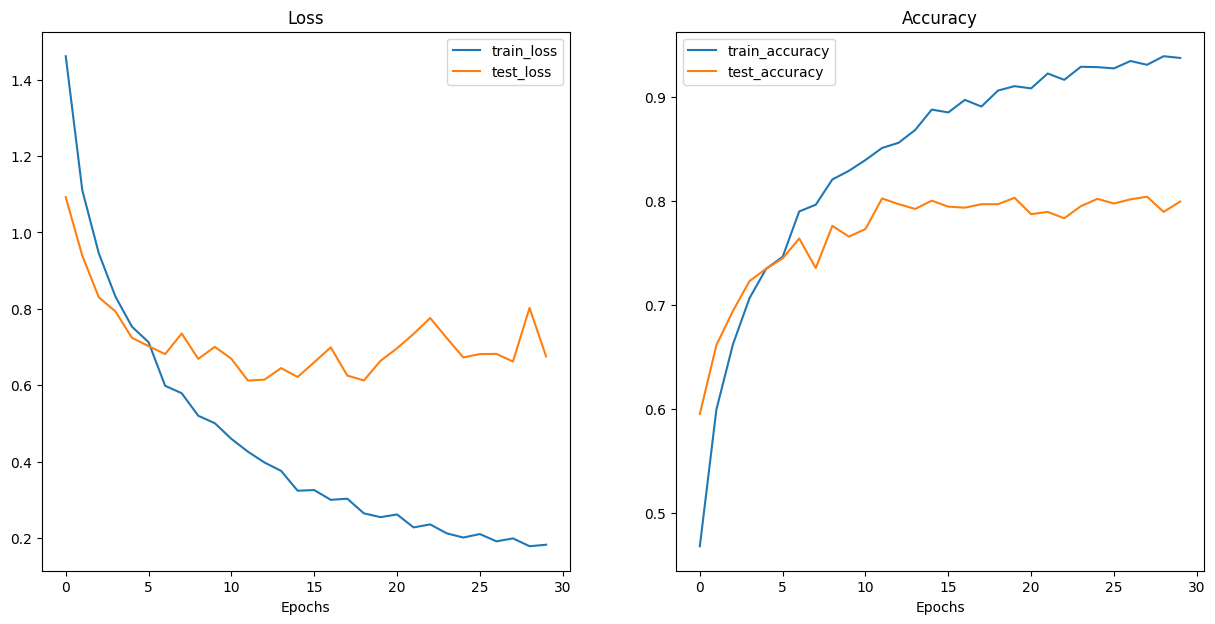

In [109]:
plot_loss_curves(model_0_results)

Judging by the plot results, we see that our model is overfitting despite using `Dropout()` layers and L2 regularization. This occurs very early, somewhere around the 5th epoch. As next steps of the pipeline, we will try some methods to avoid this phenomenon. We will create and evaluate some models, each of which uses a method to avoid overfitting, in order to see what methods fix the issue. The models and methods we are going to try, are:
* `model_1`: The model is going to be trained using data augmentation.
* `model_2`: We are going to use `Dropou2d()` layers in the convolution blocks.
* `model_3`: We are going to implement _learning rate scheduling_ in the training.
* `model_4`: We are going to improve the batch normalization by using `InstanceNorm2d()` instead of `BatchNorm2d()`
* `model_5`: Use all of the above in a model.

## 8. Using Data Augmentation

For our next model we are going to use data augmentation. This is a very common method to avoid overfitting. The method works as following:

During training, the model is exposed to the same data during each epoch. When implementing data augmentation, we alter the data on each epoch. In this way, the model is exposed to different data on each epoch, thus increasing the variety of data that it is exposed to. On each epoch a random alternation on the data is applied.

### 8.1 Implementing `TimeMasking()` and `FrequencyMasking()` on the data
The data augmentation we are going to use is `TimeMasking()` and `FrequencyMasking()`, both from the `torchaudio` library. Those methods will randomly mask up to a number of time frames and coefficients respectively. For more info - https://docs.pytorch.org/audio/main/tutorials/audio_feature_augmentation_tutorial.html#time-and-frequency-masking


> The `TimeMasking()` transform, "masks" the entire x axis for a specific amount. A good option would be to mask 15% of the sample. The *time_mask_param* is responsible for the amount of time frames that will be masked. We are calculating this value and setting it in the `TimeMasking()` transform.
>> __In case we divided the original GTZAN samples into 10 segments__: Our x axis is the time frames and we know that each sample has 130 time frames. We are going to mask 20 frames which is approximately 15% of the sample. This is done by setting the *time_mask_param* to 20. That means that maximum 20 consecutive frames will be masked.

> The `FrequencyMasking()` transform, "masks" the entire y axis for a specific amount. A good option would be to mask 12% of the sample. The *freq_mask_param* is responsible for the amount of mel bands that will be masked. We are calculating this value and setting it in the `FrequencyMasking()` transform.
>> __In case we divided the original GTZAN samples into 10 segments__:Our y axis is the mel bands and we know that each sample has 64 mel bands. We are going to mask 8 frames which is approximately 12% of the sample. This is done by setting the *freq_mask_param* to 8. That means that maximum 8 consecutive frames will be masked.

The masked spectograms are presented, to have a visualization of the augmented data. Similar methods of masking on log mel spectograms directly are mentioned in the SpecAugment paper. More info here - https://arxiv.org/pdf/1904.08779

_**Notice**: The time_mask_param and freq_mask_param will set the **maximum** amount of frames/MFCCs that will be masked. This number will be random on each epoch._

In [110]:
# Calculating the proper time_mask_param anf freq_mask_param values
mfccs = inputs.shape[2]
time_frames = inputs.shape[1]

time_mask_param = round(time_frames * 0.15)
freq_mask_param = round(mfccs * 0.12)

time_mask_param, freq_mask_param

(20, 2)

In [172]:
# Creating time masking transform and checking the shape of sample data
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

INDEX = np.random.randint(len(X))
time_masking = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
time_masked_data = time_masking(X[INDEX].squeeze()).to('cpu')
time_masked_data.shape

torch.Size([13, 130])

In [181]:
# Creating frequency masking transform and checking the shape of sample data
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED+8)

INDEX = np.random.randint(len(X))
freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
freq_masked_data = freq_masking(X[INDEX].squeeze()).to('cpu')
freq_masked_data.shape

torch.Size([13, 130])

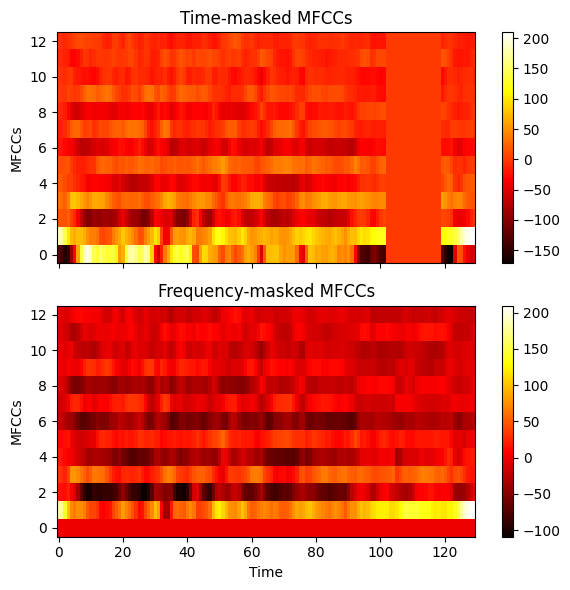

In [182]:
# Visualize data
time_masked_melspec_example = time_masked_data.numpy()
freq_masked_melspec_example = freq_masked_data.numpy()

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
im0 = axes[0].imshow(time_masked_melspec_example, cmap='hot', aspect='auto', origin='lower')
axes[0].set_title("Time-masked MFCCs")
axes[0].set_ylabel("MFCCs")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(freq_masked_melspec_example, cmap='hot', aspect='auto', origin='lower')
axes[1].set_title("Frequency-masked MFCCs")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("MFCCs")
fig.colorbar(im1, ax=axes[1])

fig.tight_layout()
plt.show()

In the frequency masked plot, we can see the first coefficient being masked.

### 8.2 Training the model with augmented data
We are going to create a new `train_step_with_augmentation()` and `train_with_augmentation` functions by altering our previous training functions in order to train the model with the augmented data. There is no need to use augmentation in validation and testing sets. The rest of the pipeline is the same. In the end we are going to plot the results to see if there is improvement.

In [114]:
# Creating the transform instance
from torchaudio import transforms as T

torch.manual_seed(RANDOM_SEED)

train_transforms = nn.Sequential(
    T.TimeMasking(time_mask_param=time_mask_param),
    T.FrequencyMasking(freq_mask_param=freq_mask_param)
)

# Create a train loop function
def train_step_with_augmentation(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               use_augmentation=True):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Implement augmentation
        if use_augmentation:
            X = train_transforms(X)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [115]:
# Creating the function for training with data that have been augmented
def train_with_augmentation(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step_with_augmentation(model=model,
                                                            dataloader=train_dataloader,
                                                            loss_fn=loss_fn,
                                                            optimizer=optimizer,
                                                             use_augmentation=True)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [116]:
# Instantiating a new model and putting it to device
torch.manual_seed(RANDOM_SEED)

model_1 = CNNClassifierV0(input_shape=1,
                          hidden_units=32,
                          output_shape=10).to(device)
model_1

CNNClassifierV0(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3

In [117]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

In [118]:
# Training the model using the train_with_augmentation function
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train_with_augmentation(model=model_1,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=validation_dataloader,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5567 | train_acc: 0.4364 | test_loss: 1.1956 | test_acc: 0.5490
Epoch: 2 | train_loss: 1.2047 | train_acc: 0.5609 | test_loss: 0.9901 | test_acc: 0.6286
Epoch: 3 | train_loss: 1.0754 | train_acc: 0.6091 | test_loss: 0.8653 | test_acc: 0.6875
Epoch: 4 | train_loss: 0.9837 | train_acc: 0.6473 | test_loss: 0.8260 | test_acc: 0.6912
Epoch: 5 | train_loss: 0.9167 | train_acc: 0.6789 | test_loss: 0.7842 | test_acc: 0.7169
Epoch: 6 | train_loss: 0.8728 | train_acc: 0.6888 | test_loss: 0.8171 | test_acc: 0.7102
Epoch: 7 | train_loss: 0.7956 | train_acc: 0.7274 | test_loss: 0.6947 | test_acc: 0.7523
Epoch: 8 | train_loss: 0.7614 | train_acc: 0.7313 | test_loss: 0.6642 | test_acc: 0.7724
Epoch: 9 | train_loss: 0.7530 | train_acc: 0.7320 | test_loss: 0.7366 | test_acc: 0.7391
Epoch: 10 | train_loss: 0.7097 | train_acc: 0.7516 | test_loss: 0.6886 | test_acc: 0.7664
Epoch: 11 | train_loss: 0.6955 | train_acc: 0.7552 | test_loss: 0.6062 | test_acc: 0.7852
Epoch: 12 | train_l

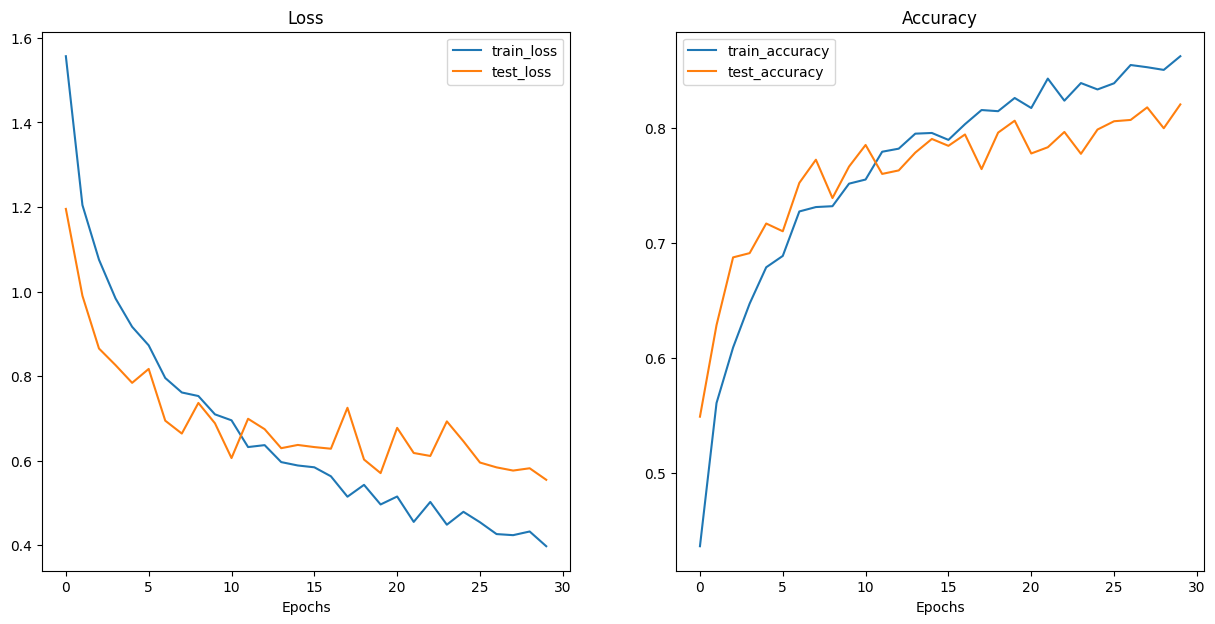

In [119]:
plot_loss_curves(model_1_results)

## 9. Using Dropout2d

We will add a `Dropout2d()` layer in each convolution block. This layer will zero out entire channels. It is a common practise in convolution networks. More info here - https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html

We will have to build a new class for the classifier, as well as instantiate a new model. The rest of the pipeline is the same.

In [120]:
# Compile the network
class CNNClassifierV1(nn.Module):
    def __init__(self, input_shape: int = 1,
                 hidden_units:int = 32,
                 output_shape: int = 10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout2d(0.3)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout2d(0.3)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2,
                         padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout2d(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 1 * 16,
                      64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

# Create a model and put it to device
torch.manual_seed(RANDOM_SEED)

model_2 = CNNClassifierV0(input_shape=1,
                          hidden_units=32,
                          output_shape=10).to(device)
model_2

CNNClassifierV0(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3

In [121]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

In [122]:
# Training the model using the train function
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4686 | train_acc: 0.4627 | test_loss: 1.1181 | test_acc: 0.5930
Epoch: 2 | train_loss: 1.0877 | train_acc: 0.6126 | test_loss: 0.9806 | test_acc: 0.6404
Epoch: 3 | train_loss: 0.9340 | train_acc: 0.6688 | test_loss: 0.8626 | test_acc: 0.6914
Epoch: 4 | train_loss: 0.8174 | train_acc: 0.7151 | test_loss: 0.7072 | test_acc: 0.7562
Epoch: 5 | train_loss: 0.7299 | train_acc: 0.7397 | test_loss: 0.7023 | test_acc: 0.7641
Epoch: 6 | train_loss: 0.6505 | train_acc: 0.7730 | test_loss: 0.6885 | test_acc: 0.7580
Epoch: 7 | train_loss: 0.6037 | train_acc: 0.7888 | test_loss: 0.6429 | test_acc: 0.7866
Epoch: 8 | train_loss: 0.5509 | train_acc: 0.8109 | test_loss: 0.6202 | test_acc: 0.7891
Epoch: 9 | train_loss: 0.4937 | train_acc: 0.8246 | test_loss: 0.6186 | test_acc: 0.7879
Epoch: 10 | train_loss: 0.4394 | train_acc: 0.8470 | test_loss: 0.6122 | test_acc: 0.7879
Epoch: 11 | train_loss: 0.4241 | train_acc: 0.8515 | test_loss: 0.5901 | test_acc: 0.7953
Epoch: 12 | train_l

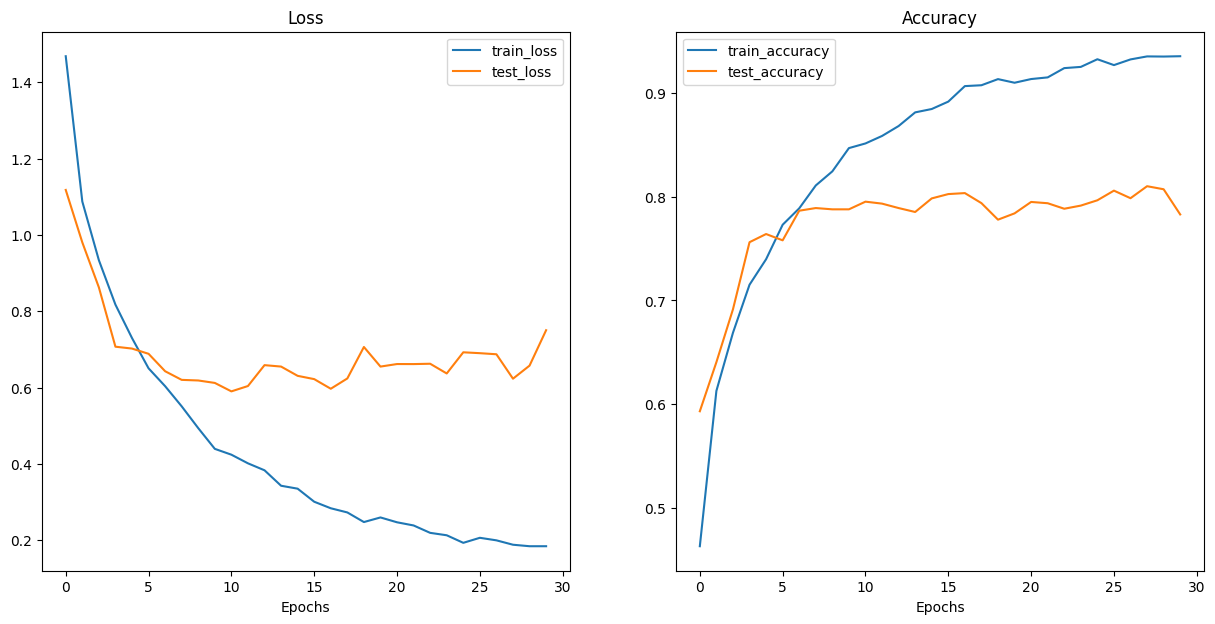

In [123]:
plot_loss_curves(model_2_results)

## 10. Learning rate scheduling

The concept of learning rate scheduling is adjusting the learning rate of the optimizer while training. The objective that we seek to achieve with the method of gradient descent is to find values for the weights and biases that produce the least error. The *learing rate* hypeprameter is very crucial to this algorithm. A very high learning rate can lead to difficulty to find the local minimum of the error function, whereas a low learning rate can lead to slow training. Learning rate scheduling, adjusts the value of the learning rate in various ways instead of having a steady value. We are going to use the *Adaptive Plateau Reduction* approach, which is implemented by the `ReduceLROnPlateau()` method. For more info on learning rate scheduling - https://machinelearningmastery.com/a-gentle-introduction-to-learning-rate-schedulers/

In order to include learning rate scheduling in the training, we have to instantiate a `ReduceLROnPlateau` instance and include it in our `train()` function. In this manner, our train function will now be `train_with_scheduler()`. Furthermore, the value of the learning rate in each epoch will also be saved and included in the dictionary that the function returns. As a result, we will be able to spot when the learning rate changes, in case that happens.

The rest of the pipeline is the same.

In [124]:
# Create a model and put it to device
torch.manual_seed(RANDOM_SEED)

model_3 = CNNClassifierV0(input_shape=1,
                          hidden_units=32,
                          output_shape=10).to(device)
model_3

CNNClassifierV0(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3

In [125]:
# Create loss, optimizer and scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

scheduler = ReduceLROnPlateau(optimizer,
                             mode='min',
                             factor=0.5,
                             patience=5)

In [126]:
# Create train function by combining train_step and test_step
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train_w_scheduler(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # Update scheduler if it exists
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()

        # Saving the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        results["learning_rates"].append(current_lr)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [127]:
# Training the model using the train function
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_3_results = train_w_scheduler(model=model_3,
                                    train_dataloader=train_dataloader,
                                    test_dataloader=validation_dataloader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=NUM_EPOCHS,
                                    scheduler=scheduler)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4686 | train_acc: 0.4627 | test_loss: 1.1181 | test_acc: 0.5930 | LR: 0.001000
Epoch: 2 | train_loss: 1.0877 | train_acc: 0.6126 | test_loss: 0.9806 | test_acc: 0.6404 | LR: 0.001000
Epoch: 3 | train_loss: 0.9340 | train_acc: 0.6688 | test_loss: 0.8626 | test_acc: 0.6914 | LR: 0.001000
Epoch: 4 | train_loss: 0.8174 | train_acc: 0.7151 | test_loss: 0.7072 | test_acc: 0.7562 | LR: 0.001000
Epoch: 5 | train_loss: 0.7299 | train_acc: 0.7397 | test_loss: 0.7023 | test_acc: 0.7641 | LR: 0.001000
Epoch: 6 | train_loss: 0.6505 | train_acc: 0.7730 | test_loss: 0.6885 | test_acc: 0.7580 | LR: 0.001000
Epoch: 7 | train_loss: 0.6037 | train_acc: 0.7888 | test_loss: 0.6429 | test_acc: 0.7866 | LR: 0.001000
Epoch: 8 | train_loss: 0.5509 | train_acc: 0.8109 | test_loss: 0.6202 | test_acc: 0.7891 | LR: 0.001000
Epoch: 9 | train_loss: 0.4937 | train_acc: 0.8246 | test_loss: 0.6186 | test_acc: 0.7879 | LR: 0.001000
Epoch: 10 | train_loss: 0.4394 | train_acc: 0.8470 | test_loss: 

We can see that the learning rate changes in epoch #17 and #25.

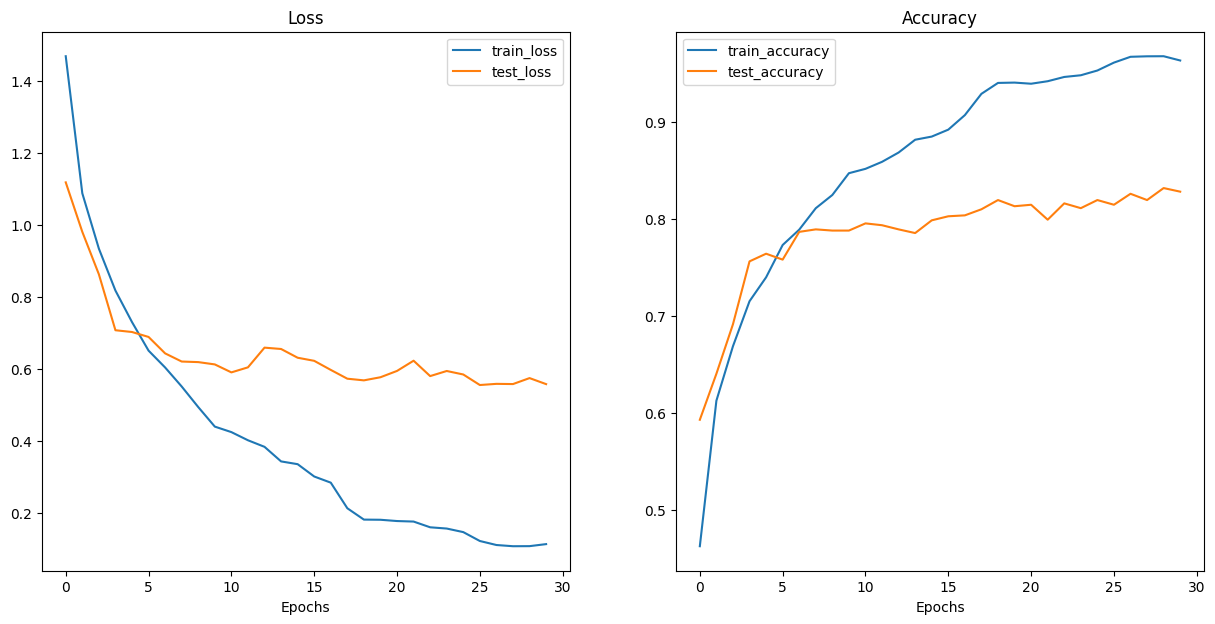

In [128]:
plot_loss_curves(model_3_results)

## 11. Using Instance Normalization instead of Batch Normalization

Instance normalization normalizes each input individually focusing only on its own features. This is more like giving personalized feedback to each student without comparing them to others. For more info - https://stackoverflow.com/questions/45463778/instance-normalisation-vs-batch-normalisation

In order to use Instance Normalization, we will replace the `BatchNorm2d()` layers with `InstanceNorm2d()` in the convolution blocks. So we have to create a new Classifier class and a new model. Other than that, the pipeline is the same.

In [129]:
# Compile the network
class CNNClassifierV2(nn.Module):
    def __init__(self, input_shape: int = 1,
                 hidden_units:int = 32,
                 output_shape: int = 10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.InstanceNorm2d(hidden_units)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.InstanceNorm2d(hidden_units)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2,
                         padding=1),
            nn.InstanceNorm2d(hidden_units)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 1 * 16,
                      64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

# Create a model and put it to device
torch.manual_seed(RANDOM_SEED)

model_4 = CNNClassifierV2(input_shape=1,
                          hidden_units=32,
                          output_shape=10).to(device)
model_4

CNNClassifierV2(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2)

In [130]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

In [131]:
# Training the model using the train function
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2882 | train_acc: 0.1428 | test_loss: 2.1943 | test_acc: 0.1874
Epoch: 2 | train_loss: 2.0291 | train_acc: 0.2753 | test_loss: 1.9557 | test_acc: 0.2855
Epoch: 3 | train_loss: 1.8099 | train_acc: 0.3435 | test_loss: 1.8350 | test_acc: 0.3174
Epoch: 4 | train_loss: 1.6757 | train_acc: 0.3898 | test_loss: 1.7374 | test_acc: 0.3676
Epoch: 5 | train_loss: 1.5529 | train_acc: 0.4429 | test_loss: 1.7206 | test_acc: 0.3774
Epoch: 6 | train_loss: 1.4815 | train_acc: 0.4698 | test_loss: 1.6919 | test_acc: 0.3837
Epoch: 7 | train_loss: 1.3862 | train_acc: 0.5077 | test_loss: 1.6758 | test_acc: 0.4028
Epoch: 8 | train_loss: 1.3150 | train_acc: 0.5312 | test_loss: 1.6823 | test_acc: 0.4087
Epoch: 9 | train_loss: 1.2514 | train_acc: 0.5516 | test_loss: 1.6672 | test_acc: 0.4143
Epoch: 10 | train_loss: 1.1834 | train_acc: 0.5746 | test_loss: 1.6988 | test_acc: 0.4165
Epoch: 11 | train_loss: 1.1137 | train_acc: 0.6037 | test_loss: 1.7099 | test_acc: 0.4126
Epoch: 12 | train_l

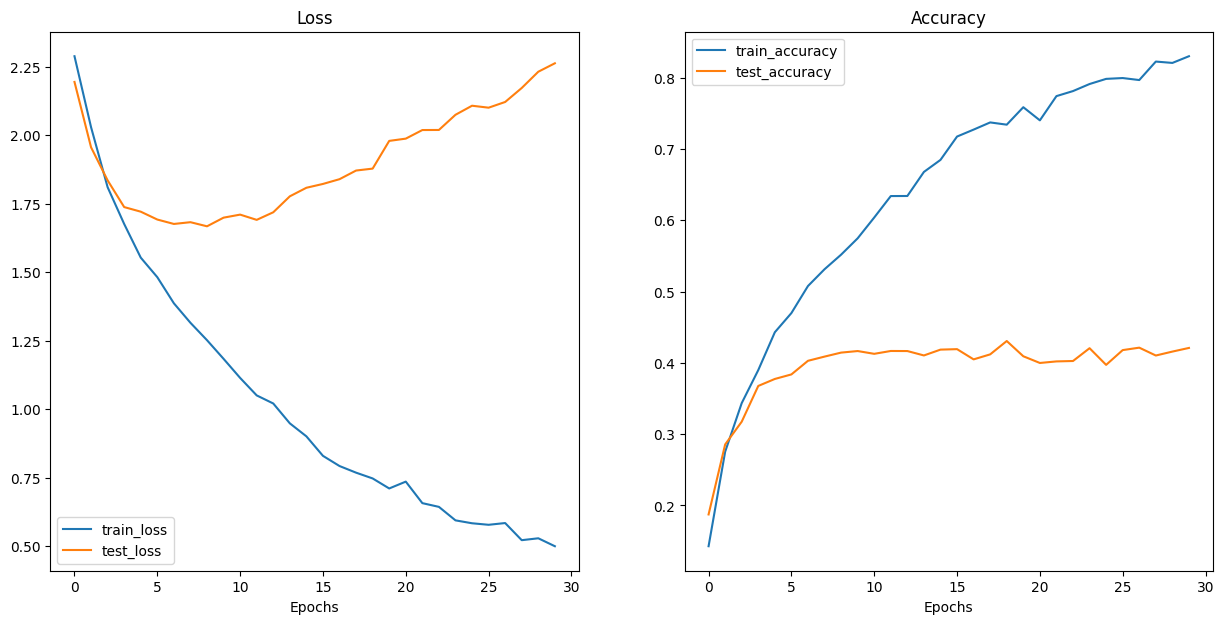

In [132]:
plot_loss_curves(model_4_results)

## 12. Create model to combine all previous methods

We are going to combine all the previous methods. The new Classifier class is going to have `Dropout2d()` layers as well as `InstanceNorm2d()` layers. We are going to use `ReduceLROnPlateau()` for the scheduler, as well as train with augmented data. Finally, we are going to train the model for 200 epochs.

In [133]:
# Compile the network
class CNNClassifierV3(nn.Module):
    def __init__(self, input_shape: int = 1,
                 hidden_units:int = 32,
                 output_shape: int = 10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.Dropout2d(0.3)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.Dropout2d(0.3)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2,
                         padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.Dropout2d(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 1 * 16,
                      64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

# Create a model and put it to device
torch.manual_seed(RANDOM_SEED)

model_5 = CNNClassifierV3(input_shape=1,
                          hidden_units=32,
                          output_shape=10).to(device)
model_5

CNNClassifierV3(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (classifier):

In [134]:
# Create loss, optimizer and scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

scheduler = ReduceLROnPlateau(optimizer,
                             mode='min',
                             factor=0.5,
                             patience=5)

In [135]:
# Create train function by combining train_step and test_step
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train_with_augmented_data_and_scheduler(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step_with_augmentation(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # update scheduler if it exists
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()

        # saving the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        results["learning_rates"].append(current_lr)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [136]:
# Training the model using the train function
# Set number of epochs
NUM_EPOCHS = 200

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3
model_5_results = train_with_augmented_data_and_scheduler(model=model_5,
                                                        train_dataloader=train_dataloader,
                                                        test_dataloader=validation_dataloader,
                                                        optimizer=optimizer,
                                                        loss_fn=loss_fn,
                                                        epochs=NUM_EPOCHS,
                                                        scheduler=scheduler)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3428 | train_acc: 0.1028 | test_loss: 2.2936 | test_acc: 0.1339 | LR: 0.001000
Epoch: 2 | train_loss: 2.3081 | train_acc: 0.1188 | test_loss: 2.2728 | test_acc: 0.1461 | LR: 0.001000
Epoch: 3 | train_loss: 2.2751 | train_acc: 0.1453 | test_loss: 2.2336 | test_acc: 0.1761 | LR: 0.001000
Epoch: 4 | train_loss: 2.2222 | train_acc: 0.1764 | test_loss: 2.1713 | test_acc: 0.2153 | LR: 0.001000
Epoch: 5 | train_loss: 2.1664 | train_acc: 0.1983 | test_loss: 2.1013 | test_acc: 0.2200 | LR: 0.001000
Epoch: 6 | train_loss: 2.0966 | train_acc: 0.2241 | test_loss: 2.0371 | test_acc: 0.2388 | LR: 0.001000
Epoch: 7 | train_loss: 2.0322 | train_acc: 0.2453 | test_loss: 1.9907 | test_acc: 0.2621 | LR: 0.001000
Epoch: 8 | train_loss: 1.9861 | train_acc: 0.2786 | test_loss: 1.9399 | test_acc: 0.2835 | LR: 0.001000
Epoch: 9 | train_loss: 1.9510 | train_acc: 0.2828 | test_loss: 1.9042 | test_acc: 0.2862 | LR: 0.001000
Epoch: 10 | train_loss: 1.9360 | train_acc: 0.2824 | test_loss: 

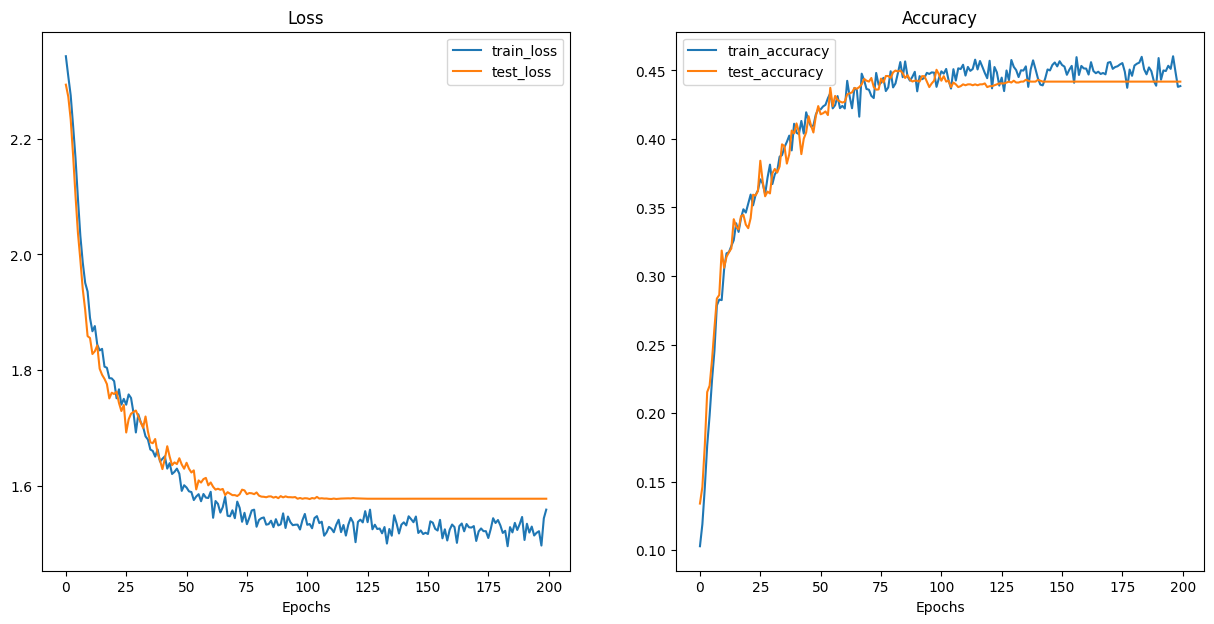

In [137]:
plot_loss_curves(model_5_results)

After considering each loss and accuracy plot, we can see the following:
* `model_1`: This model is perhaps the best one. We can see that overfitting was fixed and only with 30 epochs, it reaches an approximately 75% accuracy on the validation set.
* `model_2`: The overfitting issue was not fixed.
* `model_3`: The overfitting issue was not fixed.
* `model_4`: The overfitting issue was not fixed. It even worsened
* `model_5`: Overfitting was fixed. However, the model performs very poorly. After 100 epochs, accuracy plateaus at around 41%. Learning rate becomes 0 on epoch #136 after being gradually reduced, due to learning rate scheduling.

## 13. Evaluating our best model on never seen data

Finally, we are going to use the `test_dataloader` to evaluate `model_1` which was our best performing model.

In [138]:
# Evaluate the CNN on the test set
evaluation = test_step(model=model_1,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       )
print(f"test loss = {evaluation[0]:.4f} | test acc = {evaluation[1]:.4f}")

test loss = 0.5463 | test acc = 0.8291


## 14. Creating a `predict()` function, to make predictions on unseen data

We are going to use `model_1` to make predictions. First we use the test dataloader to extract the first sample. Then we create the predict function that among other arguments, we can enter the index of the sample we want to predict. We see that we have 2499 indexes available.
The tensor that represents the sample has to be unsqueezed because the model expects a `batch_size` on dim=0. The model exports logits. Using `softmax()` we turn the logits into probabilities and with `argmax()` we take the index of the highest probability. This is actually the predicted index class. However, we can use `argmax()` right away without having the probabilites first. This is because logit values are respective to the probability values. This is actually the predicted index class. We also do that for time complexity reasons.

In [139]:
# Creating the predict() function
def predict(model: torch.nn.Module,
            X_test: torch.Tensor,
            y_test: torch.Tensor,
            index: int = 0,
            device: str = "cpu",
            classes: list = classes):

    X_sample = X_test[index].unsqueeze(0).to(device)  # (1, C, H, W)
    y_sample = y_test[index].item() if isinstance(y_test[index], torch.Tensor) else y_test[index]

    model.eval()
    with torch.inference_mode():
        logits = model(X_sample)
        predicted_index = torch.argmax(logits, dim=1).item()

    print(f"Target: {classes[y_sample]}, Predicted label: {classes[predicted_index]}")

In [140]:
# Checking shape of X_test. There are 2499 samples
X_test.shape

torch.Size([2499, 1, 13, 130])

In [141]:
# Set random seed to define index.
np.random.seed(RANDOM_SEED) # remove this line to set a random index, for further testing
index = np.random.randint(len(X_test))

predict(model=model_1,
        X_test=X_test,
        y_test=y_test,
        index=index,
        device=device,
        classes=classes)

Target: country, Predicted label: country


## 15. Making a confusion matrix for further evaluation

For a good vizualization of our model's performance, we can use a confusion matrix. For that purpose we will use the `torchmetrics` and `mlxtend` library.
First we will make predictions on a test set and save the results on a tensor. Then we can use this tensor along with `y_test` which is a tensor containing the correct values for the labels of the test set.

In [142]:
# Importing libraries
import mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher. use pip install -q torchmetrics -U mlxtend"

mlxtend version: 0.23.4


In [143]:
# Make predictions on test_set and get tensor with predictions
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/79 [00:00<?, ?it/s]

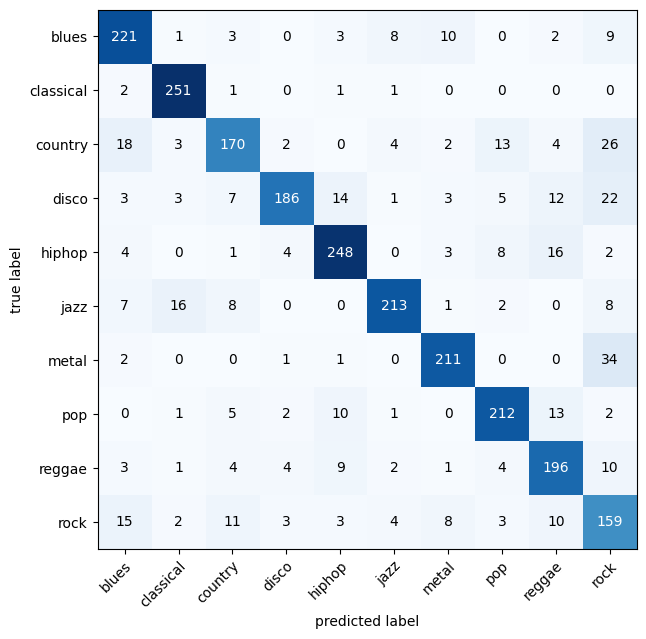

In [144]:
# Importing libraries
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test)

#  Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

We can see that our model performs quite well. One of the benefits of the confusion matrix, is that we can see what labels our model mismatches. We can see that the highest mismatch values appear between country and rock, hiphop and reggae, metal and rock. This is interesting, because those genres could be difficult to be distinguished from a human as well. We do not see that much errors in distinguishing that many genres for classical. Furthermore, one must bear in mind that the distinction of genres is based on audio features. As a result, one can expect mismatches genres that use similar instruments or music production.